# Analizando datos del cluster de Univalle

En este *notebook* se mostrarán las instrucciones que permitirán analizar los datos del cluster de Univalle.

El código abajo lee datos el archivo `history.csv`. 

In [11]:
import pandas as pd

CSVFILENAME = 'history-2019-09-06.csv.gz'

df = pd.read_csv(CSVFILENAME,compression="gzip",dtype='unicode')

Se usa como índice del análisis el campo `JobCurrentStartDate`.

In [13]:
INDEXFIELD = 'JobCurrentStartDate'

df[INDEXFIELD] = pd.to_datetime(df[INDEXFIELD], unit='s')
df = df.set_index(INDEXFIELD)

A continuación se definen unas funciones auxiliares que permitirán visualizar los datos.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math

def analizarRangoAnos(ano1,ano2, log = True):
    values = [] # valores reales
    vallog = [] # valores logaritmicos
    xlabel = []
    contador = 1
    for i in range(ano1, ano2 + 1):
        for j in range(1, 13):
            fecha = '%d-%d'%(i,j)
            valT = df.loc[fecha].shape[0]
            values.append(valT)
            if valT <= 0:
                valT = 1
            if log:
                vallog.append(math.log2(valT))
            else:
                vallog.append(valT)                
            #xlabel.append(fecha)
            xlabel.append(contador)
            contador = contador + 1

    return (xlabel, vallog, values)

def analizarPorAno(ano, log = True):
    return analizarRangoAnos(ano, ano, log)

def showPlot(xlab, val):
    fit = plt.figure()
    plt.plot(xlab,val)
    plt.grid()
    plt.show()

Si usted desear revisar el de un año se ejecuta el siguiente código

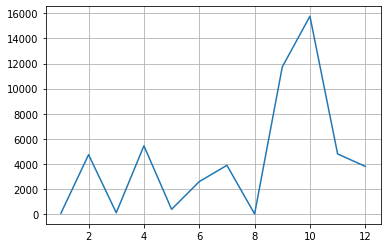

[58, 4729, 99, 5437, 371, 2583, 3881, 5, 11725, 15769, 4790, 3796]

In [15]:
(xlab, vallog, realvalues) = analizarPorAno(2016, False)
showPlot(xlab, vallog)
realvalues

Si usted desea revisar el rango de años del 2015 al 2019 se debe ejecutar el siguiente código.

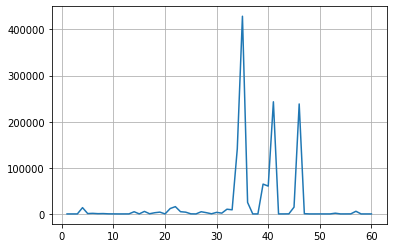

[0,
 0,
 0,
 13600,
 793,
 1215,
 529,
 750,
 205,
 97,
 14,
 35,
 58,
 4729,
 99,
 5437,
 371,
 2583,
 3881,
 5,
 11725,
 15769,
 4790,
 3796,
 182,
 1,
 4728,
 2703,
 300,
 3380,
 1692,
 10209,
 8887,
 141028,
 428553,
 24820,
 9,
 4,
 64630,
 60325,
 243110,
 23,
 24,
 142,
 14675,
 238393,
 523,
 23,
 22,
 43,
 23,
 23,
 1544,
 35,
 60,
 103,
 5723,
 0,
 0,
 0]

In [10]:
(xlab, vallog, realvalues) = analizarRangoAnos(2015, 2019, False)
showPlot(xlab, vallog)
realvalues